In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
import pandas as pd
import umap

from scCustomFunctions import *
from parameters import *

# import mnnpy
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
import mnnpy

/opt/conda/lib/python3.8/site-packages/mnnpy/utils.py:30: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 1d, A))
  dist[i, j] = np.dot(m[i], n[j])
/opt/conda/lib/python3.8/site-packages/mnnpy/utils.py:205: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, C), array(float32, 1d, A))
  scale = np.dot(working, grad)
/opt/conda/lib/python3.8/site-packages/mnnpy/utils.py:215: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, C), array(float32, 1d, A))
  curproj = np.dot(grad, curcell)
/opt/conda/lib/python3.8/site-packages/mnnpy/utils.py:219: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, C), array(float32, 1d, A))
  sameproj = np.dot(grad, samecell)
/opt/conda/lib/python3.8/site-packages/mnnpy/utils.py:229: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (a

In [4]:
a = loadData(QC_imputed=True,Normalized=True,Log1p=True)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Compute corrections

We compute batch corrections using two different algorithms

1. Harmoy
2. Fast MNN

In [10]:
def fast_mnn_correct(adata,key,key_obsm="X_pca",key_added="X_pca_MNN",order=None,**kwargs):
    
    #Sort by size if no order
    if order == None:
        orderMerge = np.unique(adata.obs[key])
        s = []
        for j in orderMerge:
            s.append(adata[adata.obs[key]==j].shape[0])
        orderMerge = orderMerge[np.argsort(-np.array(s))]
    else:
        orderMerge = order
    
    
    c = scp.AnnData(adata.obsm[key_obsm].copy())
    c.obs.index = adata.obs.index
    c.obs[key] = adata.obs[key]
    c.var.index = c.var.index.astype(str)
    l = [c[c.obs[key]==i] for i in orderMerge]
    if len(l)>1:
        c = scp.external.pp.mnn_correct(*l,verbose=True)[0]
        c.obs.index = [i.split("-")[0] for i in c.obs.index]
        sort = np.sort(c.obs.index.values.astype(int)).astype(str)
        c = c[sort]
        
    adata.obsm[key_added] = c.X.copy()
    
    return

ImportError: Please install the package mnnpy (https://github.com/chriscainx/mnnpy). 

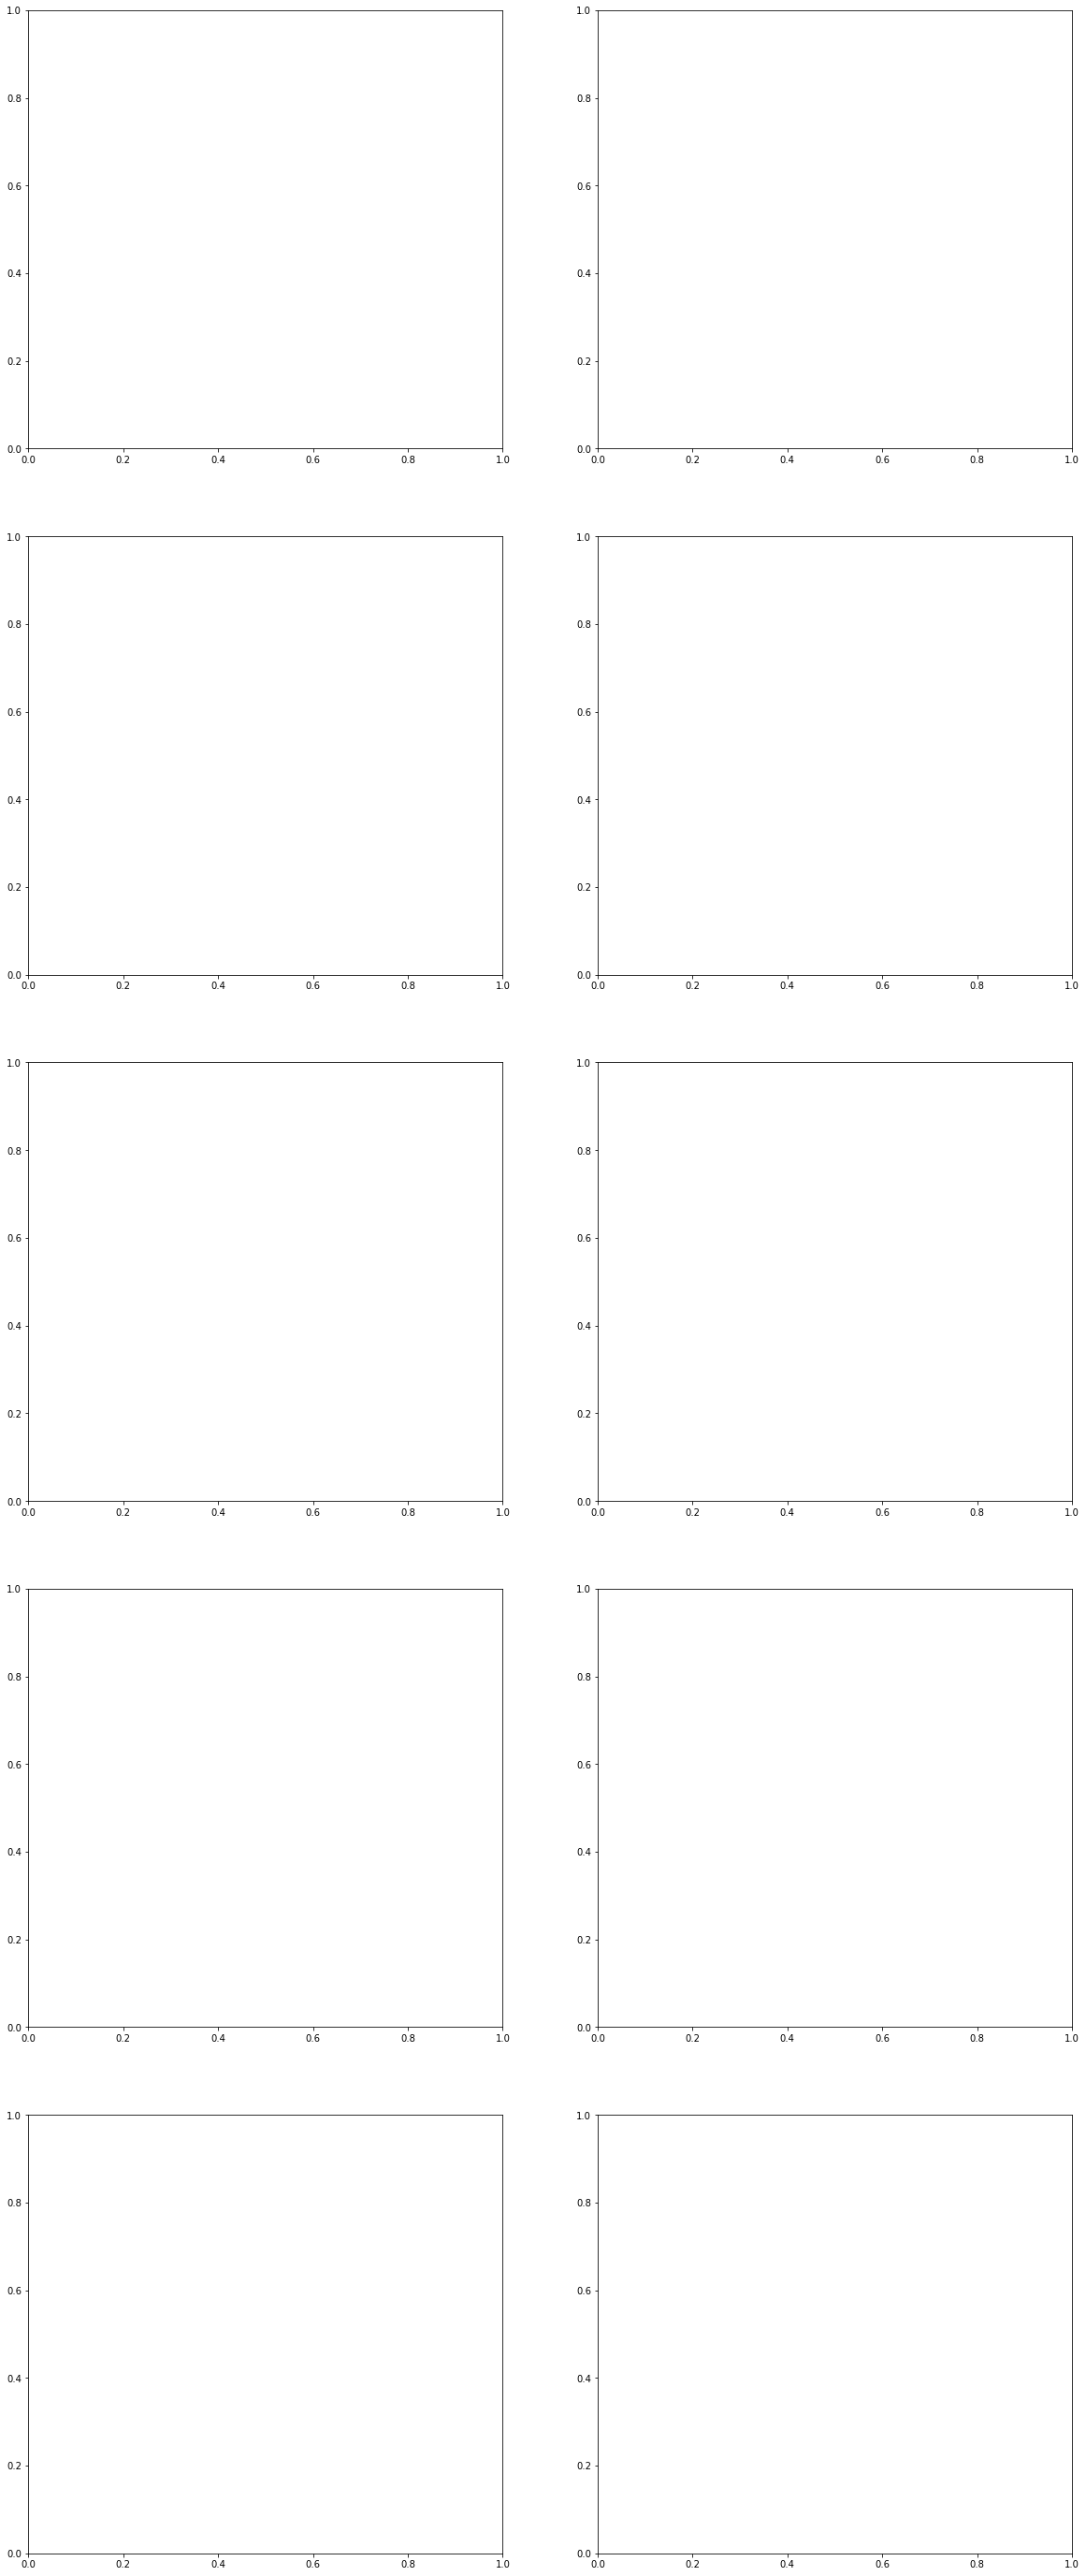

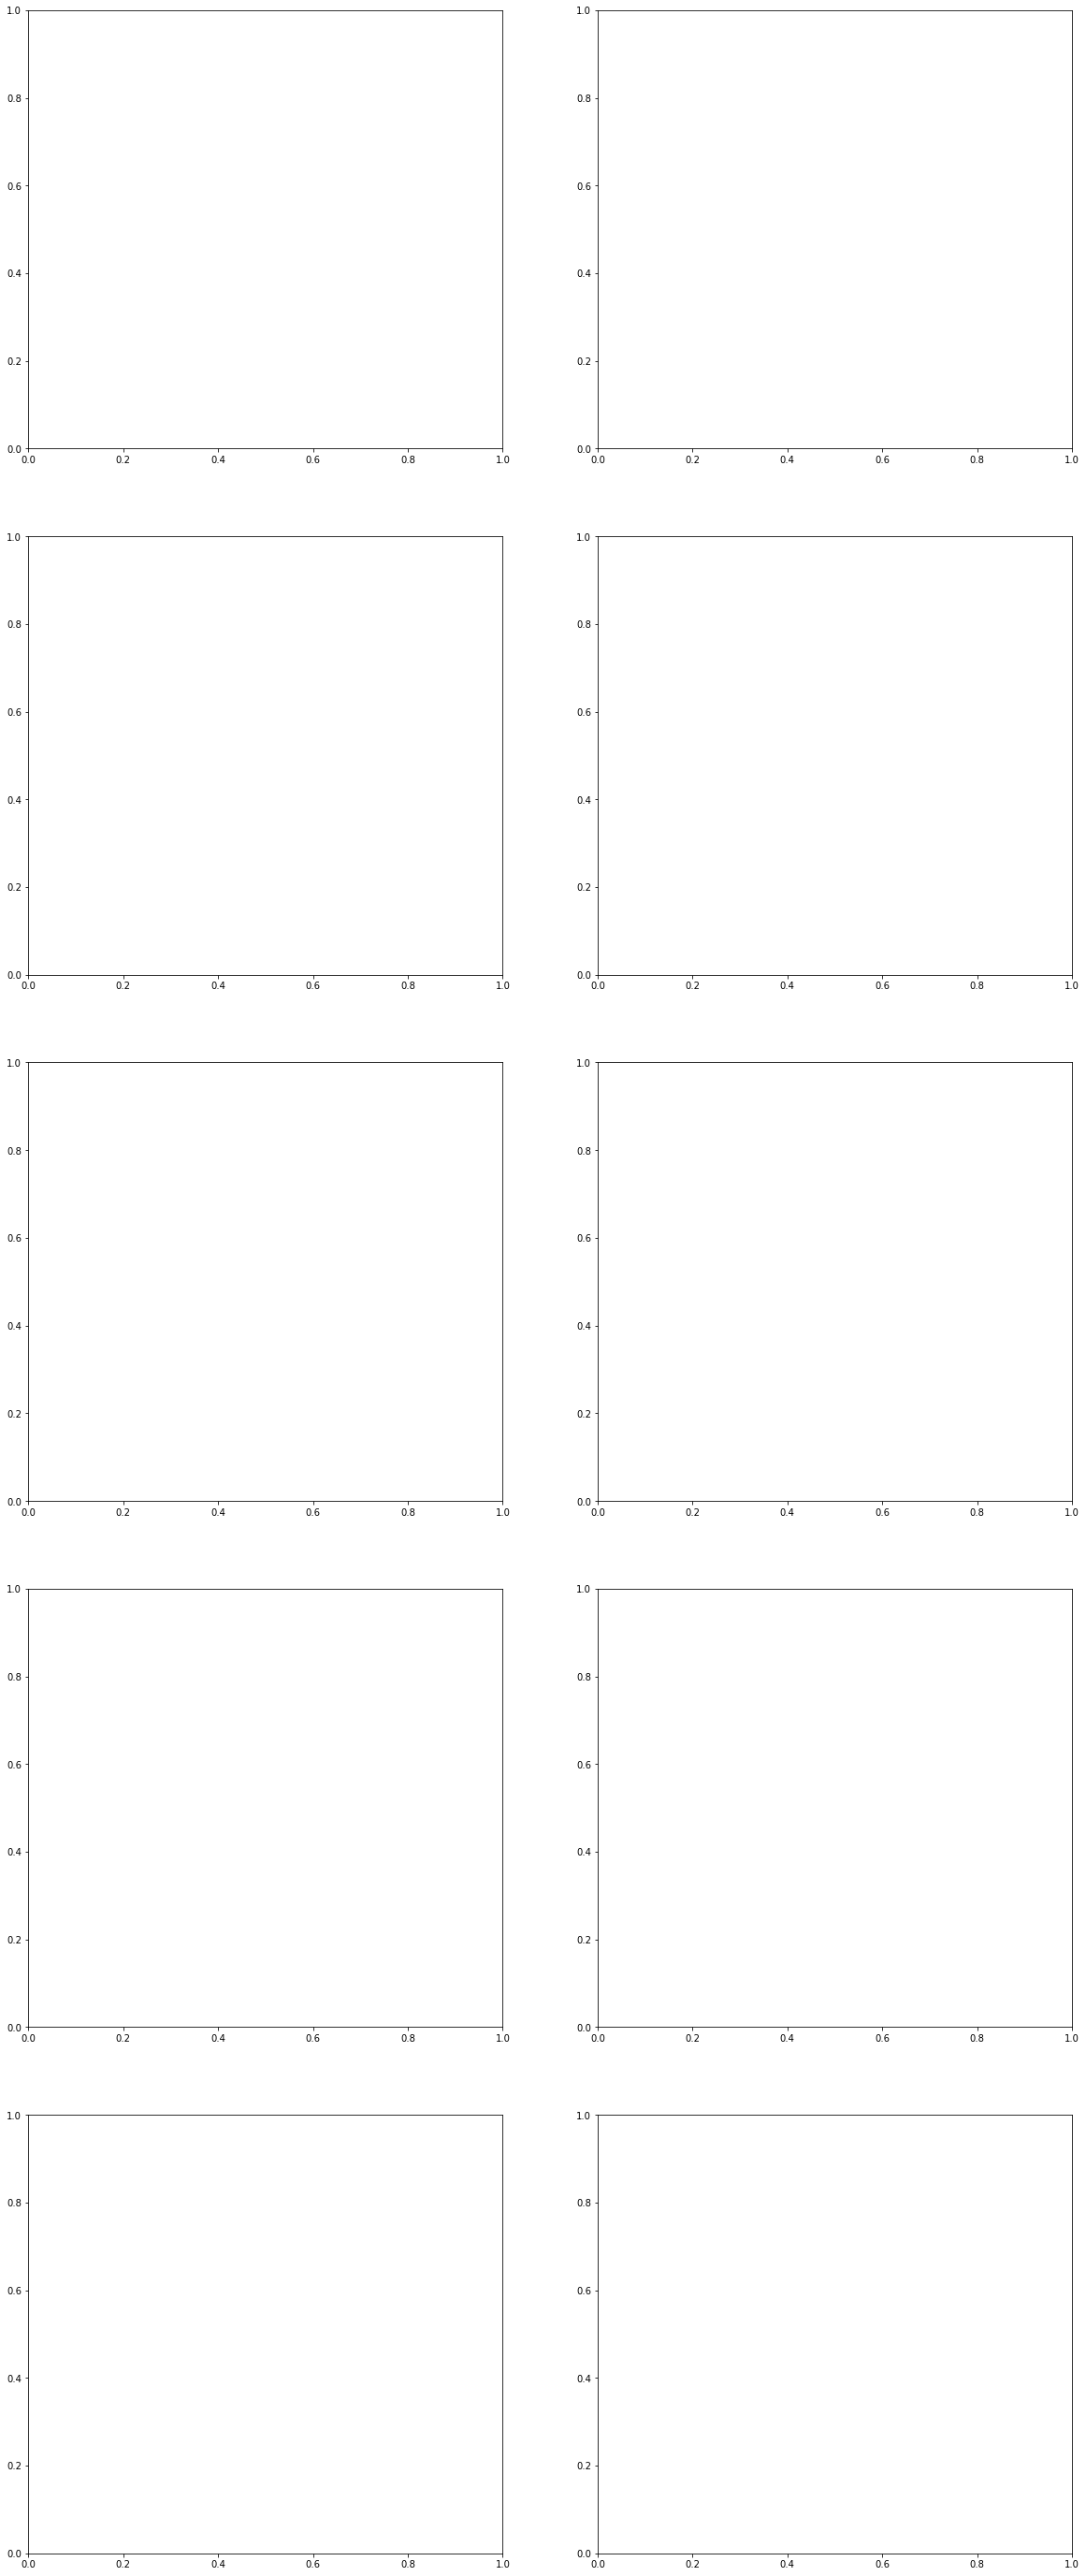

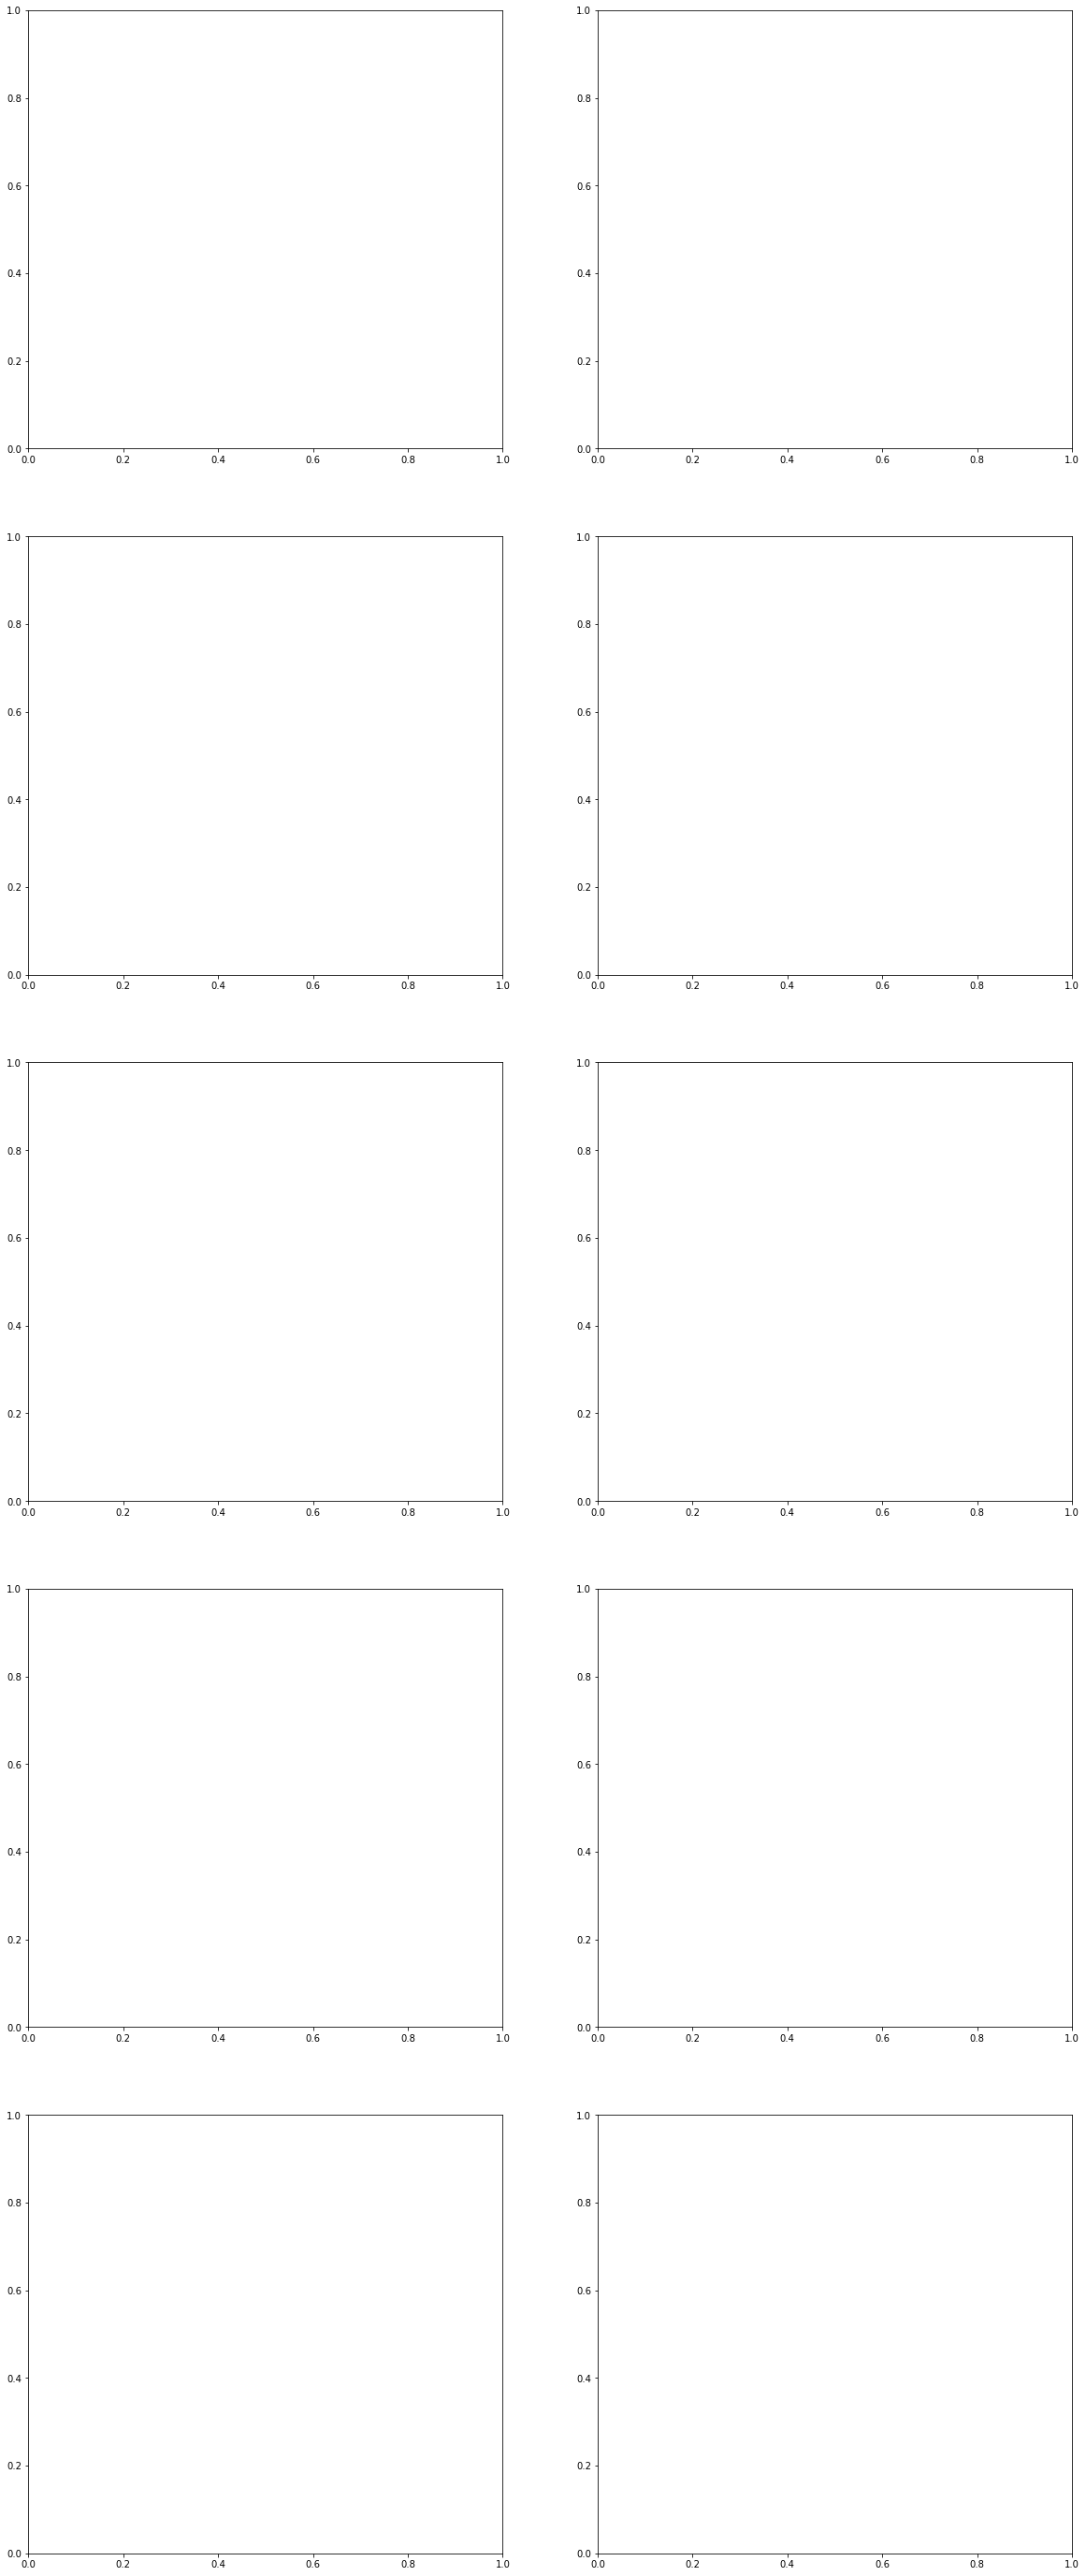

In [11]:
fig1,ax1 = plt.subplots(5,2,figsize=[20,50])
fig2,ax2 = plt.subplots(5,2,figsize=[20,50])
fig3,ax3 = plt.subplots(5,2,figsize=[20,50])
for j,stage in enumerate(np.sort(a.obs["stage"].unique())[:1]):
    
    posx = j//2
    posy = j%2

    b = a[a.obs["stage"]==stage,:].copy()
    b.obs["stage"]=b.obs["stage"].astype(str)
    b.obs["sample"]=b.obs["sample"].astype(str)
    scp.pp.highly_variable_genes(b,flavor=HVG_METHOD)
    remove_highly_variable_genes(b,SKIP_GENES) #Remove genes related with sex or cell cycle
    
    #Raw
    scp.pp.pca(b,n_comps=N_PCS,use_highly_variable=USE_HVGs)
#     scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS)
    
#     scp.tl.louvain(b,resolution=LOUVAIN_INITIALISATION)
#     scp.tl.paga(b); scp.pl.paga(b,plot=False)
#     scp.tl.umap(b,init_pos="paga")
    
#     sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax1[posx,posy])
#     ax1[posx,posy].set_title(stage)
    
#     np.save("dataOut/4_Batch_Correction/PCA_"+stage,b.obsm["X_pca"])
#     np.save("dataOut/4_Batch_Correction/UMAP_"+stage,b.obsm["X_umap"])
    
#     #Harmony
#     scp.external.pp.harmony_integrate(b,"sample")
#     scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca_harmony")
    
#     scp.tl.louvain(b,resolution=LOUVAIN_INITIALISATION)
#     scp.tl.paga(b); scp.pl.paga(b,plot=False)
#     scp.tl.umap(b,init_pos="paga")
    
#     sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax2[posx,posy])
#     ax2[posx,posy].set_title(stage)

#     np.save("dataOut/4_Batch_Correction/PCA_harmony_"+stage,b.obsm["X_pca_harmony"])
#     np.save("dataOut/4_Batch_Correction/UMAP_harmony_"+stage,b.obsm["X_umap"])
    
    #MNN
    fast_mnn_correct(b,"sample")
#     scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca_MNN")
    
#     scp.tl.louvain(b,resolution=LOUVAIN_INITIALISATION)
#     scp.tl.paga(b); scp.pl.paga(b,plot=False)
#     scp.tl.umap(b,init_pos="paga")
    
#     sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax3[posx,posy])
#     ax3[posx,posy].set_title(stage)

#     np.save("dataOut/4_Batch_Correction/PCA_mnn"+stage+".png",b.obsm["X_pca_MNN"])
#     np.save("dataOut/4_Batch_Correction/UMAP_mnn"+stage+".png",b.obsm["X_UMAP"])
    
fig1.savefig("Plots/4_Batch_Correction/Stages_without_correction_umap.png",bbox_inches="tight",transparent=True)
fig2.savefig("Plots/4_Batch_Correction/Stages_Harmony_umap.png",bbox_inches="tight",transparent=True)
fig3.savefig("Plots/4_Batch_Correction/Stages_MNN_umap.png",bbox_inches="tight",transparent=True)